Exploration of RISE with mnist binary

Function : Exploration of RISE mnist binary
Author : Team DIANNA
Contributor :
First Built : 2021.08.25
Last Update : 2021.08.25
Note : We ran the method using the our own trained model on mnist and various instances from mnist dataset. Results look random. There is no sense that we can make of the heatmaps.

In [1]:
import dianna
import onnx
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.special import softmax
from dianna.methods import RISE
from dianna import visualization

In [2]:
data = np.load('./binary-mnist.npz')
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1])/255
y_test = data['y_test']

# Predict classes for test data

In [3]:


def run_model(data):
    data = data.reshape([-1, 1, 28, 28]).astype(np.float32)*255
    fname = './mnist_model.onnx'
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    
    onnx_input = {input_name: data}
    pred_onnx = sess.run([output_name], onnx_input)
    
    return softmax(pred_onnx[0], axis=1)


pred_onnx = run_model(X_test)

Print class and image of a single instance in the test data

[1.00000000e+00 1.03046845e-16]


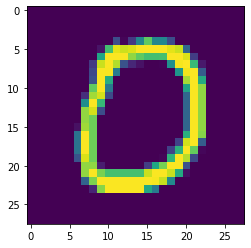

In [4]:
i_instance = 3
print(pred_onnx[i_instance])
plt.imshow(X_test[i_instance][...,0])  # 0 for channel

In [5]:
# heatmaps = dianna.explain(run_model, X_test[[i_instance]], method="RISE", n_masks=2000, feature_res=8, p_keep=0.5)

In [6]:
explainer = RISE(n_masks=2000, feature_res=8, p_keep=.8)
heatmaps = explainer(run_model, X_test[[i_instance]])

Explaining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]


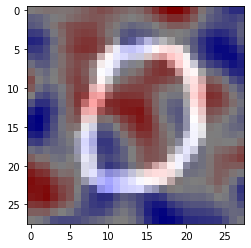

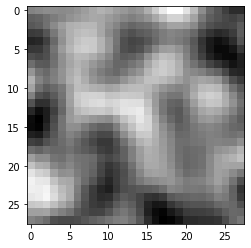

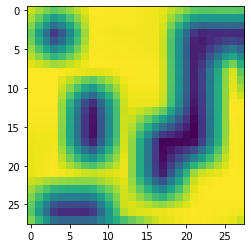

In [7]:
visualization.plot_image(heatmaps[0], X_test[i_instance], data_cmap='gray', heatmap_cmap='bwr')
visualization.plot_image(heatmaps[0], heatmap_cmap='gray')
visualization.plot_image(heatmaps[1])

In [8]:
def describe(arr):
    print('shape:',arr.shape, 'min:',np.min(arr), 'max:',np.max(arr), 'std:',np.std(arr))

describe(heatmaps[0])
describe(heatmaps[1])

shape: (28, 28) min: 0.9821080368968245 max: 1.0159467988904698 std: 0.006741828110973838
shape: (28, 28) min: 8.435820293390002e-09 max: 3.7780635045862823e-07 std: 1.0985552541757853e-07


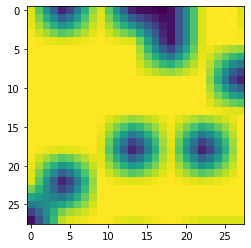

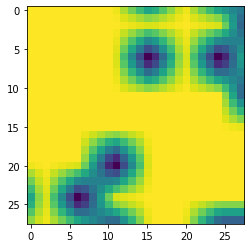

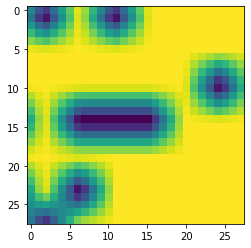

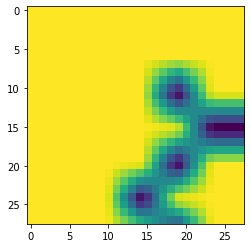

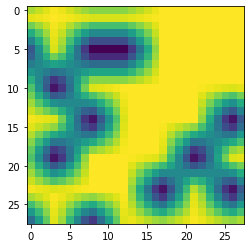

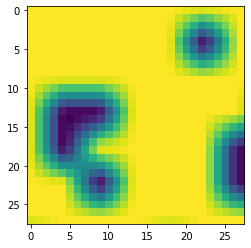

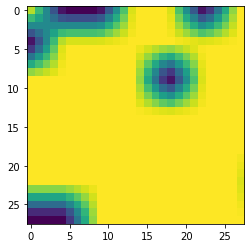

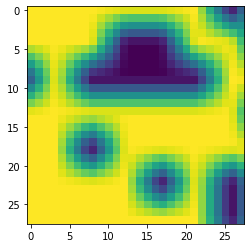

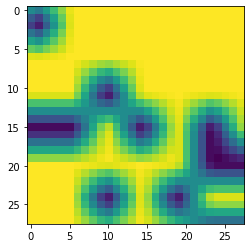

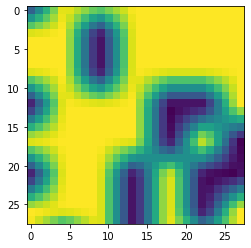

In [9]:
for i in range(10):
    plt.imshow(explainer.masks[i])
    plt.show()